<a href="https://colab.research.google.com/github/VartanyanAdik/service_by_reviews/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импортируем библиотеки

In [3]:
# Загрузка необходимых библиотек и модулей
import zipfile # Библиотека для работы с zip архивами
import os      # Библиотека для работы с фаловой системой
import time    # Библиотека для работы со временем
from google.colab import drive # Модуль для работы с Google Disk
from PIL import *  # Модуль для работы с файлами
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import re
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

# Загрузка данных и их чтение

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/My Drive/Проект от гринатом/aclImdb.zip'

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# Просмотр результата разархивации
print(os.listdir())

['.config', 'aclImdb', 'drive', 'sample_data']


In [6]:
# Пути к папкам с отзывами
positive_reviews_path_train = '/content/aclImdb/train/pos'
negative_reviews_path_train = '/content/aclImdb/train/neg'
positive_reviews_path_test = '/content/aclImdb/test/pos'
negative_reviews_path_test = '/content/aclImdb/test/neg'


# Функция для чтения отзывов из файлов
def read_reviews_from_folder(folder_path, label):
    reviews = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                review = file.read().strip()
                rating_str = filename.split('_')[1].replace('.txt', '').strip()  # Берем вторую часть и удаляем .txt
                rating = int(rating_str)  # Преобразуем в целое число
                reviews.append((review, rating, label))
    return reviews

# Чтение положительных и отрицательных отзывов
positive_reviews_train = read_reviews_from_folder(positive_reviews_path_train, 'positive')
negative_reviews_train = read_reviews_from_folder(negative_reviews_path_train, 'negative')
positive_reviews_test = read_reviews_from_folder(positive_reviews_path_test, 'positive')
negative_reviews_test = read_reviews_from_folder(negative_reviews_path_test, 'negative')


# Объединение всех отзывов в один список
all_reviews_train = positive_reviews_train + negative_reviews_train
all_reviews_test = positive_reviews_test + negative_reviews_test

# Создание и проверка датафреймов

In [7]:
# Создание DataFrame из списка отзывов
df_train = pd.DataFrame(all_reviews_train, columns=['review','rating', 'label'])

df_train

,review,rating,label
0,"A year or so ago, I was watching the TV news w...",9,positive
1,What people fail to understand about this movi...,9,positive
2,I have seen a lot of Saura films and always fo...,10,positive
3,"""And the time came when the risk to remain tig...",8,positive
4,"Bruce Almighty is the story of Bruce Nolan, an...",7,positive
...,...,...,...
24995,"Follow-up to 1973's ""Walking Tall"" continues t...",1,negative
24996,"This film is horrible. Bad acting, bad writing...",1,negative
24997,How Disney can you get? Preppy rich girls act ...,2,negative
24998,Uwe Boll has done the impossible: create a gam...,4,negative


In [8]:
# Создание DataFrame из списка отзывов
df_test = pd.DataFrame(all_reviews_test, columns=['review', 'rating', 'label'])

df_test

,review,rating,label
0,Hoppity is a charming if slightly phycadelic a...,7,positive
1,"To be frank, this is probably the best version...",10,positive
2,I wish I could have met Ida Lupino. When peopl...,7,positive
3,I saw this film on 19SEP2009 at the Cambridge ...,8,positive
4,This was easily one of the weirder of the Erne...,7,positive
...,...,...,...
24995,"Now, I love bad, old skifee movies as much as ...",1,negative
24996,I made sure to see this film because it is a 1...,4,negative
24997,I enjoy science-fiction just as much as the ne...,4,negative
24998,He seems to be a control freak. I have heard h...,1,negative


In [9]:
df_train.shape

(25000, 3)

In [10]:
df_test.shape

(25000, 3)

In [11]:
df_train.head()

,review,rating,label
0,"A year or so ago, I was watching the TV news w...",9,positive
1,What people fail to understand about this movi...,9,positive
2,I have seen a lot of Saura films and always fo...,10,positive
3,"""And the time came when the risk to remain tig...",8,positive
4,"Bruce Almighty is the story of Bruce Nolan, an...",7,positive


In [12]:
df_test.head()

,review,rating,label
0,Hoppity is a charming if slightly phycadelic a...,7,positive
1,"To be frank, this is probably the best version...",10,positive
2,I wish I could have met Ida Lupino. When peopl...,7,positive
3,I saw this film on 19SEP2009 at the Cambridge ...,8,positive
4,This was easily one of the weirder of the Erne...,7,positive


# Очистка и преобразование данных

In [13]:
import nltk

# Загрузка стоп-слов
nltk.download('wordnet')
nltk.download('stopwords')
# Загрузка стоп-слов
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Приведение текста к нижнему регистру
    text = text.lower()
    # Удаление HTML-тегов
    text = re.sub(r'<.*?>', '', text)
    # Удаление специальных символов и цифр
    text = re.sub(r'[^a-z\s]', '', text)
    # Токенизация и удаление стоп-слов
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
df_train['review'] = df_train['review'].apply(clean_text)
df_test['review'] = df_test['review'].apply(clean_text)

In [15]:
df_train

,review,rating,label
0,year ago watching tv news story broadcast zomb...,9,positive
1,people fail understand movie isnt beginning mi...,9,positive
2,seen lot saura film always found amazing way a...,10,positive
3,time came risk remain tight bud painful risk t...,8,positive
4,bruce almighty story bruce nolan average man f...,7,positive
...,...,...,...
24995,followup walking tall continues reallife drama...,1,negative
24996,film horrible bad acting bad writing bad music...,1,negative
24997,disney get preppy rich girl act like idiot buy...,2,negative
24998,uwe boll done impossible create game adaptatio...,4,negative


In [16]:
df_test

,review,rating,label
0,hoppity charming slightly phycadelic animated ...,7,positive
1,frank probably best version book sound movie v...,10,positive
2,wish could met ida lupino people ask could ext...,7,positive
3,saw film sep cambridge film festival beagle co...,8,positive
4,easily one weirder ernest movie especially reg...,7,positive
...,...,...,...
24995,love bad old skifee movie much people understa...,1,negative
24996,made sure see film scifi filmone favorite genr...,4,negative
24997,enjoy sciencefiction much next man hell appare...,4,negative
24998,seems control freak heard comment losing contr...,1,negative


In [17]:
df_train['label'] = df_train['label'].map({'positive': 1, 'negative': 0})
df_test['label'] = df_test['label'].map({'positive': 1, 'negative': 0})

In [18]:
# Разделим df_train на X (отзывы) и y (метки)
X_train = df_train['review']
y_train = df_train['label']
X_test = df_test['review']
y_test = df_test['label']

# Моделирование

In [19]:
# Создаем пайплайн с векторизацией и логистической регрессией
pipeline_logres = make_pipeline(TfidfVectorizer(), LogisticRegression())

# Обучаем модель
pipeline_logres.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [20]:
# Тестируем модель
y_pred = pipeline_logres.predict(X_test)
print(classification_report(y_test, y_pred), 'roc auc score', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000
 roc auc score 0.87844


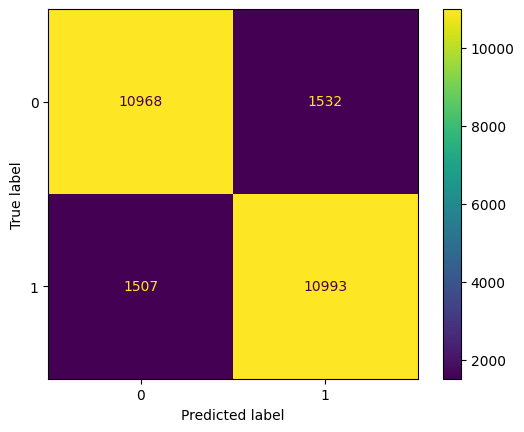

In [21]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
